# So we took a look at the data...

In [55]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from nltk.tokenize import word_tokenize

In [56]:
train = pd.read_csv('./propaganda_dataset_v2/propaganda_train.tsv', header=0, quoting=3, sep='\t')
test = pd.read_csv('./propaganda_dataset_v2/propaganda_val.tsv', header=0, quoting=3, sep='\t')

dataset = pd.concat([train, test])

In [57]:
propaganda_count = len(dataset[dataset['label'] != 'not_propaganda' ])
propaganda_count

1600

In [58]:
len(train[train['label'] != 'not_propaganda']) / len(train)

0.504296875

In [59]:
len(test[test['label'] != 'not_propaganda']) / len(test)

0.4828125

In [60]:
labels = set(dataset['label'])
labels 

{'appeal_to_fear_prejudice',
 'causal_oversimplification',
 'doubt',
 'exaggeration,minimisation',
 'flag_waving',
 'loaded_language',
 'name_calling,labeling',
 'not_propaganda',
 'repetition'}

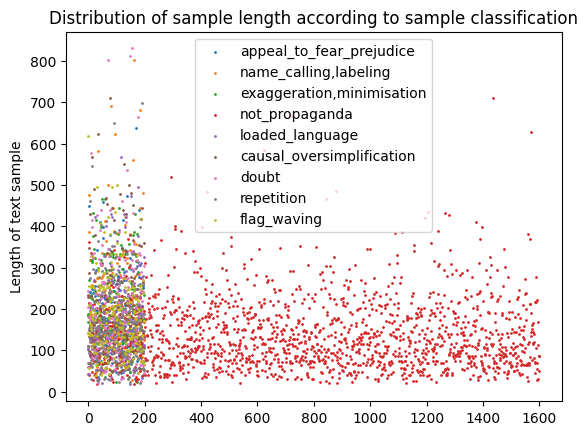

In [61]:
sorted_dataset = {label: list(dataset[dataset['label'] == label]['tagged_in_context']) for label in labels}
sample_lengths = {label: [len(text_sample) for text_sample in text_samples] for label, text_samples in sorted_dataset.items()}


for label, lengths in sample_lengths.items():
    plt.scatter(np.arange(0, len(lengths)), lengths, label=label, s=1)

plt.title("Distribution of sample length according to sample classification")
plt.ylabel("Length of text sample")
plt.legend()
plt.show()

In [62]:
{ label:np.mean(lengths) for label, lengths in sample_lengths.items() }

{'appeal_to_fear_prejudice': 184.315,
 'name_calling,labeling': 211.87,
 'exaggeration,minimisation': 190.99,
 'not_propaganda': 137.50125,
 'loaded_language': 179.785,
 'causal_oversimplification': 205.785,
 'doubt': 197.29,
 'repetition': 161.68,
 'flag_waving': 187.43}

# Average Number of Words 

In [71]:
avg_word_count = {label: np.round(np.mean([len(word_tokenize(sample)) for sample in samples]), decimals=1) for label, samples in sorted_dataset.items()}
for label, avg_word_count in avg_word_count.items():
    print(f"{label.title()} & {avg_word_count} \\\\")

Appeal_To_Fear_Prejudice & 39.6 \\

Name_Calling,Labeling & 44.5 \\

Exaggeration,Minimisation & 40.0 \\

Not_Propaganda & 30.0 \\

Loaded_Language & 37.7 \\

Causal_Oversimplification & 43.6 \\

Doubt & 41.6 \\

Repetition & 34.4 \\

Flag_Waving & 40.0 \\